![DSME-logo](./utils/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Notebook Authors: Lukas Kesper

In this example, we use the policy iteration algorithm to find an optimal policy for the recycling bot from "Reinforcement Learning: An Introduction." An overview of the MDP that belongs to the recycling bot is shown below. The robot has a battery, whose state can be high or low. When having a high battery level, the agent can search or wait for cans. When being in a low battery state, the agent can also recharge, to prevent running out of battery.

<img src="./utils/recycling_bot.jpg" alt="Policy Iteration algorithm" width="500">

Reference: [Reinforcement Learning: An Introduction, by Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/book/the-book-2nd.html)

## Library Imports

In [1]:
%matplotlib inline
import gymnasium as gym
import numpy as np
import custom_envs
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
from IPython.display import display
from screeninfo import get_monitors
from typing import Optional

## Initializations
### Initializing the MDP

Dynamic Programming (DP) algorithms are a class of algorithms capable of finding the optimal policy for an environment, given a model of the environment. Below, we implement such a model in the class `MarkovDecisionProcess`. The class identifies the number of states in `self.num_states`, as well as the state dependent actions in `self.actions_per_state`. Furthermore, it contains the state transition probabilities, as well as the successor states and rewards in `self.P`.

In [2]:
class MarkovDecisionProcess():
    def __init__(self, env):
        self.num_states = env.observation_space.n
        self.P = env.unwrapped.P
        self.actions_per_state = [] # list containing the actions available per state
        for state in self.P:
            actions = list(self.P[state].keys())
            self.actions_per_state.append(actions)

### Initializing the Agent
The DP Agent uses the MDP to obtain an optimal policy via the optimization algorithm. This is done using the method `train`. In this example, we consider policy iteration. The algorithm obtains an optimal policy by switching between the evaluation of a policy to obtain a value function, and using the value function to improve the policy. This is done until the policy converges. Below, we provide an overview of the algorithm.

<img src="./utils/policy_iteration.png" alt="Policy Iteration algorithm" width="500">   

The training loop can be found in the method `train`. Since we are trying to find a policy for the recycling bot, we have implemented the method `train` with a state-dependent action space. This is rather unusual, as most environments are based on uniform action spaces.
Furthermore, the algorithm also offers the option of using in-place updates for policy evaluation. For further details, we refer to the lecture.

In [3]:
class Agent():
    def __init__(self, mdp, gamma=0.9, update_threshold=1e-6):
        self.mdp = mdp
        self.update_threshold = update_threshold # stopping criterium for the updates of policy and value function
        self.state_value_fn = np.zeros(self.mdp.num_states) # table leading from state to value expectations
        # Create random policy
        self.policy = []
        for state in range(self.mdp.num_states):
            random_entry = random.randint(0, len(self.mdp.actions_per_state[state])-1)
            self.policy.append([0 for _ in range(len(self.mdp.actions_per_state[state]))])
            self.policy[state][random_entry] = 1
        self.gamma = gamma # discount factor

    def get_greedy_action(self, state):
        # Choose action based on the probabilities defined within the policy
        action = np.random.choice(np.flatnonzero(np.isclose(self.policy[state], max(self.policy[state]), rtol=0.01)))
        return action

    def train(self, in_place=False):
        policy_stable = False
        iteration = 0
        total_sweeps = 0
        while not policy_stable:
            iteration += 1
            # Policy Evaluation
            total_sweeps += self.policy_evaluation(in_place)
            # Policy Improvement
            policy_stable = self.policy_improvement()
        print('Sweeps required for convergence ', str(total_sweeps))
        print('Iterations required for convergence ', str(iteration))

    def policy_evaluation(self, in_place=True): # in_place version
        sweeps = 0
        stable = False
        while not stable:
            delta = 0
            sweeps += 1
            if in_place:
                for state in range(self.mdp.num_states):
                    old_state_value = self.state_value_fn[state]
                    new_state_value = 0
                    # sum over potential actions
                    for action in range(len(self.mdp.actions_per_state[state])):
                        new_state_value += self.get_state_value(state, action)
                    self.state_value_fn[state] = new_state_value
                    delta = max(delta, np.abs(old_state_value - self.state_value_fn[state]))
                if delta < self.update_threshold:
                    stable = True
            else:
                new_state_value_fn = np.copy(self.state_value_fn)
                for state in range(self.mdp.num_states):
                    old_state_value = self.state_value_fn[state]
                    new_state_value = 0
                    # sum over potential actions
                    for action in range(len(self.mdp.actions_per_state[state])):
                        new_state_value += self.get_state_value(state, action)
                    new_state_value_fn[state] = new_state_value
                    delta = max(delta, np.abs(old_state_value - self.state_value_fn[state]))
                if delta < self.update_threshold:
                    stable = True
                self.state_value_fn = new_state_value_fn
        return sweeps

    def get_state_value(self, state, action):
        # Value expectation considering the policy
        policy_value = 0
        for transition in self.mdp.P[state][action]:
            transition_prob = transition[0]  # prob of next state
            successor_state = transition[1]  # value/name of next state
            reward = transition[2]  # reward of next state
            policy_value += self.policy[state][action] * transition_prob * (reward + self.gamma * self.state_value_fn[successor_state])
        return policy_value
    
    def get_action_value(self, state, action):
        # Value expectation without considering the policy
        action_value = 0
        for transition in self.mdp.P[state][action]:
            transition_prob = transition[0]  # prob of next state
            successor_state = transition[1]  # value/name of next state
            reward = transition[2]  # reward of next state
            action_value += transition_prob * (reward + self.gamma * self.state_value_fn[successor_state])
        return action_value

    def policy_improvement(self):
        policy_stable = True
        current_policy = self.policy # Cache current policy
        best_policy = []
        for state in range(self.mdp.num_states):
            best_policy.append([0 for _ in range(len(self.mdp.actions_per_state[state]))])
            # Calculate best possible policy based on current value function
            action_values = []
            for action in range(len(self.mdp.actions_per_state[state])):
                action_values.append(self.get_action_value(state, action))
            best_actions = np.where(action_values == max(action_values))[0]
            for index in best_actions:
                best_policy[state][index] = 1
            best_policy[state] = [best_policy[state][action] / len(best_actions)
                                  for action in range(len(self.mdp.actions_per_state[state]))]
            # If the current policy is not the best policy, update it
            if not np.array_equal(current_policy[state], best_policy[state]):
                policy_stable = False
                self.policy[state] = best_policy[state]
        self.visualize()
        return policy_stable

### Preparing the Evaluation

For evaluating the trained agent, we implement methods that can show us the value function (`visualize`) and the policy (`render_policy`). We also add the method `evaluate`, which allows us to show samples from an agent's policy in a video.

In [4]:
def visualize(self):
    x_axis = 1
    y_axis = 2
    X1 = np.reshape(self.state_value_fn, (x_axis, y_axis))
    fig, ax = plt.subplots(1, 1)
    cmap = matplotlib.colormaps.get_cmap("Blues_r")
    cmap.set_under("black")
    img = ax.imshow(X1, interpolation="nearest", vmin=-2.5, vmax=max(self.state_value_fn), cmap=cmap)
    ax.axis('off')
    for i in range(x_axis):
        for j in range(y_axis):
            ax.text(j, i, str(X1[i][j])[:4], fontsize=12, color='black', ha='center', va='center')
    plt.show()
    self.render_policy()

def render_policy(self):
    print('Policy of the agent:')
    out = ' | '
    render = out
    for i in range(self.mdp.num_states):
        token = ""
        if self.policy[i][0] > 0:   # search
            token += "Search"
        if self.policy[i][1] > 0:   # wait
            if token != "":
                token += " or Wait"
            else:
                token += "Wait"
        if len(self.policy[i]) > 2:
            if self.policy[i][2] > 0:   # recharge
                if token != "":
                    token += " and Recharge"
                else:
                    token += "Recharge"
        render += token + out
    print(render)

def evaluate(self, env, file, num_runs=5):
    frames = []  # collect rgb_image of agent env interaction
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        out = env.render()
        frames.append(out)
        while not done:
            action = self.get_greedy_action(obs)
            obs, reward, done, truncated, info = env.step(action)
            out = env.render()
            for i in range(len(out)):
                frames.append([out[i]])
    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0][0])
        def animate(index):
            img.set_data(frames[index][0])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=3) 

setattr(Agent, 'visualize', visualize)
setattr(Agent, 'render_policy', render_policy)
setattr(Agent, 'evaluate', evaluate)

## Training and Evaluation
Now we train the agent with the algorithm we implemented earlier.

### Setting up Agent and Environment
We start by setting up the environment, which is part of our custom environments. We create the environment using `Gymnasium`, and extract its properties via our `MarkovDecisionProcess` class. Then, we can set up an Agent that we can train. We see that our initial Value function only contains zeros (state "low" is displayed in the left square; state "high" is displayed in the right square).

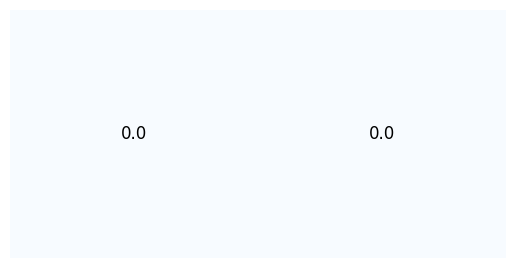

Policy of the agent:
 | Recharge | Search | 


In [5]:
env = gym.make('RecyclingRobot-v1', render_mode='text')
env.reset()
mdp = MarkovDecisionProcess(env) # in our case contains dynamics function
agent = Agent(mdp, gamma=0.9, update_threshold=0.05)
agent.visualize()

### Training

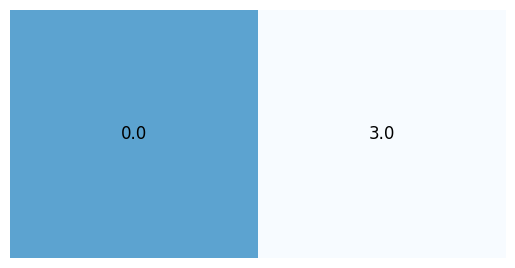

Policy of the agent:
 | Recharge | Search | 
Sweeps required for convergence  1
Iterations required for convergence  1


In [6]:
agent.train()

### Evaluation
The solution for the environment is a fairly simple behavior policy. If the agent is in the state "high", it searches for cans; if the state is "low", it recharges itself. This way, the agent receives the highest possible return. Below we show the resulting behavior highlighted in the MDP.

In [7]:
env = gym.make('RecyclingRobot-v1', render_mode='rgb_array', render_type='node')
num_runs=5
video_file_1 = "policy_iteration.mp4"
agent.evaluate(env, video_file_1, num_runs)
Video(video_file_1, html_attributes="loop autoplay")